In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Ruta del archivo en Google Drive
file_path = "/content/drive/My Drive/Womens_Clothing_Reviews.csv"

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB
None
         Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.5000

<ipython-input-5-8752a49ca8b8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Rating"], palette="viridis")


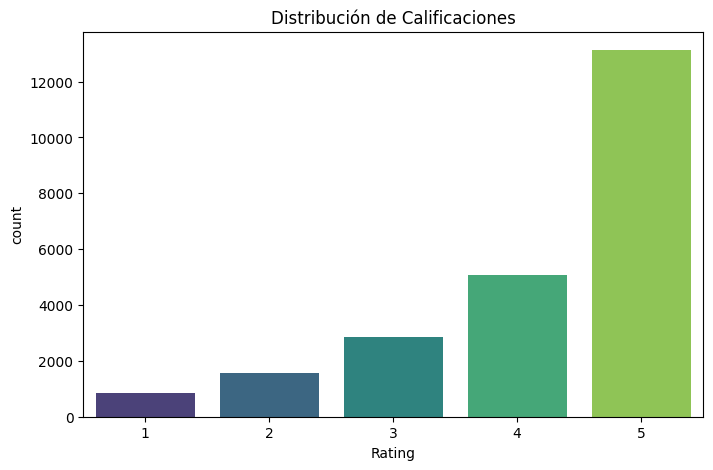

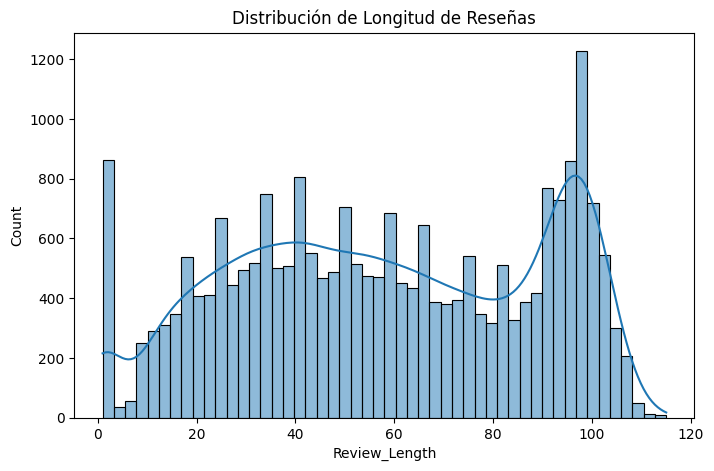

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el dataset
file_path = "/content/drive/My Drive/Womens_Clothing_Reviews.csv"
df = pd.read_csv(file_path)

# Vista general del dataset
print(df.info())  # Ver tipos de datos y valores nulos
print(df.describe())  # Estadísticas generales

# Distribución de ratings
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Rating"], palette="viridis")
plt.title("Distribución de Calificaciones")
plt.show()

# Cantidad de palabras por reseña
df["Review_Length"] = df["Review Text"].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df["Review_Length"], bins=50, kde=True)
plt.title("Distribución de Longitud de Reseñas")
plt.show()


Preprocesamiento

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Descargar recursos de NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    if pd.isnull(text):  # Manejar valores NaN
        return ""

    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r"\W", " ", text)  # Eliminar caracteres especiales
    text = re.sub(r"\d+", "", text)  # Eliminar números
    text = " ".join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])  # Lematización
    text = " ".join([stemmer.stem(word) for word in text.split()])  # Stemming
    return text

# Aplicar limpieza de texto
df["Cleaned_Review"] = df["Review Text"].astype(str).apply(clean_text)

# Crear bigramas
vectorizer = CountVectorizer(ngram_range=(1,2))
X_bigrams = vectorizer.fit_transform(df["Cleaned_Review"])

print(f"Ejemplo de bigramas: {vectorizer.get_feature_names_out()[:10]}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Ejemplo de bigramas: ['______' '______ pro' '_______' '_______ con' '_______ pro' '________'
 '________ con' '________ pro' '_________' '_________ con']


<ipython-input-7-f4a4a7b86ea5>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_bigrams["Bigram"], x=df_bigrams["Frequency"], palette="magma")


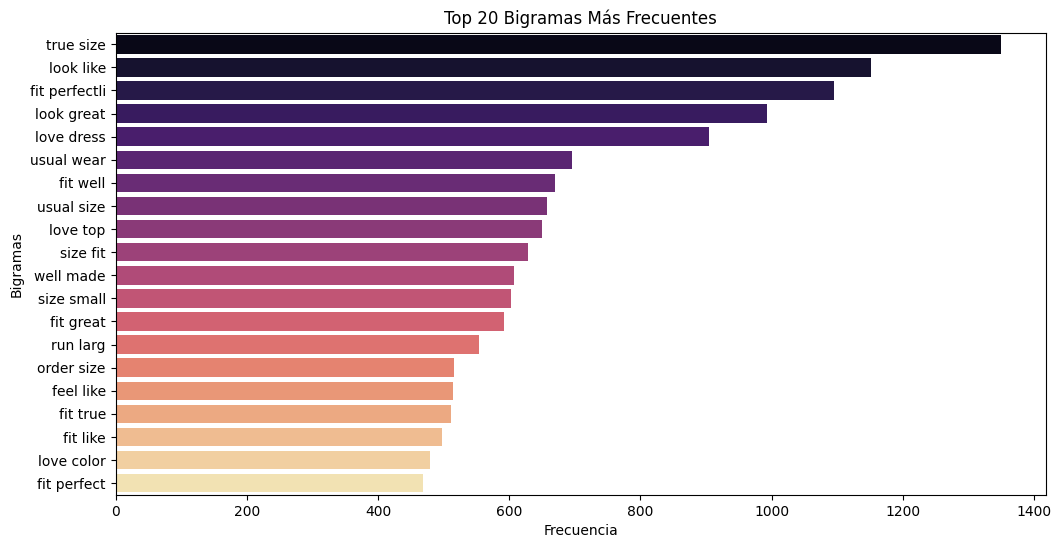

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Crear bigramas con CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=1000)  # Solo bigramas
X_bigrams = vectorizer.fit_transform(df["Cleaned_Review"])

# Contar la frecuencia de los bigramas
bigram_freq = X_bigrams.toarray().sum(axis=0)
bigram_names = vectorizer.get_feature_names_out()

# Crear un diccionario de bigramas con sus frecuencias
bigram_dict = dict(zip(bigram_names, bigram_freq))

# Tomar los 20 bigramas más frecuentes
top_bigrams = Counter(bigram_dict).most_common(20)

# Convertir a DataFrame para graficar
df_bigrams = pd.DataFrame(top_bigrams, columns=["Bigram", "Frequency"])

# 📊 Graficar los bigramas más frecuentes
plt.figure(figsize=(12,6))
sns.barplot(y=df_bigrams["Bigram"], x=df_bigrams["Frequency"], palette="magma")
plt.title("Top 20 Bigramas Más Frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Bigramas")
plt.show()


ANÁLISIS DE SENTIMIENTOS

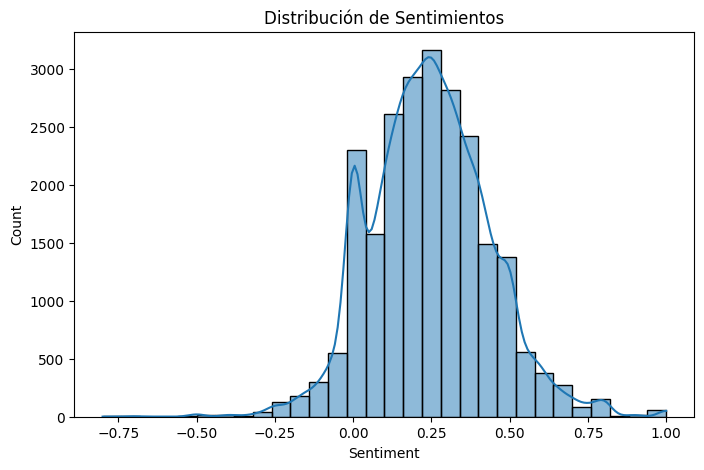

In [11]:
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

df["Sentiment"] = df["Cleaned_Review"].apply(sentiment_analysis)

# Visualizar distribución de sentimiento
plt.figure(figsize=(8, 5))
sns.histplot(df["Sentiment"], bins=30, kde=True)
plt.title("Distribución de Sentimientos")
plt.show()


MODELO MULTINOMIAL NB

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Transformar texto a TF-IDF
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X = vectorizer.fit_transform(df["Cleaned_Review"])

# Usar 'Rating' como variable objetivo (convertir a binario: positivo vs negativo)
df["Target"] = df["Rating"].apply(lambda x: 1 if x >= 4 else 0)

# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, df["Target"], test_size=0.2, random_state=42)

# Entrenar modelo
model = MultinomialNB()
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
print("Precisión del modelo:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.8495104299702001
              precision    recall  f1-score   support

           0       0.86      0.42      0.57      1090
           1       0.85      0.98      0.91      3608

    accuracy                           0.85      4698
   macro avg       0.85      0.70      0.74      4698
weighted avg       0.85      0.85      0.83      4698



MODELO RANDOM FOREST

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [14]:
df = pd.read_csv(file_path)
df = df.dropna(subset=['Review Text'])  # Eliminar filas sin texto de reseña

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
# Download 'punkt_tab' if it's not already downloaded
nltk.download('punkt_tab')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para lematización

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    tokens = word_tokenize(text)  # Tokenización
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return " ".join(tokens)

df['processed_text'] = df['Review Text'].apply(preprocess_text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Bigrama incluido
X = vectorizer.fit_transform(df['processed_text'])
y = df['Recommended IND']  # Variable objetivo


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Precisión del modelo: 0.8633252373592405

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.33      0.47       820
           1       0.87      0.98      0.92      3709

    accuracy                           0.86      4529
   macro avg       0.83      0.66      0.70      4529
weighted avg       0.86      0.86      0.84      4529



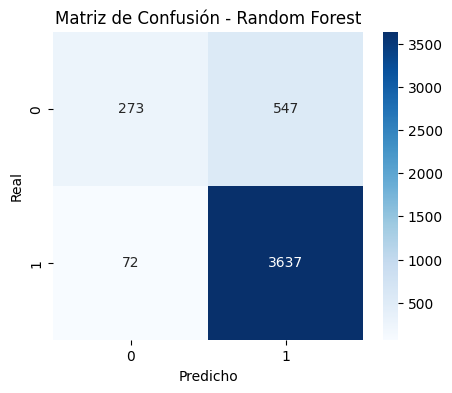

In [21]:
y_pred = rf_model.predict(X_test)

print("Precisión del modelo:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()


Usar SMOTE para equilibrar las clases y reentrenar el modelo

In [22]:
!pip install imbalanced-learn


In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [24]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar SMOTE en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [26]:
# Crear y entrenar el modelo Random Forest
rfs = RandomForestClassifier(n_estimators=100, random_state=42)
rfs.fit(X_train_resampled, y_train_resampled)

# Predicciones
y_pred = rfs.predict(X_test)

# Evaluar el modelo
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred)}")
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Precisión del modelo: 0.8642084345330094

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.66      0.51      0.58       820
           1       0.90      0.94      0.92      3709

    accuracy                           0.86      4529
   macro avg       0.78      0.73      0.75      4529
weighted avg       0.85      0.86      0.86      4529



Ajuste de hiperparámetros

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de búsqueda
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rfs = RandomForestClassifier(random_state=42)

# Aplicar RandomizedSearchCV
rfs_search = RandomizedSearchCV(rfs, param_distributions=param_dist,
                               n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

rfs_search.fit(X_train_resampled, y_train_resampled)

# Mejor modelo
best_rfs = rfs_search.best_estimator_

# Evaluar
y_pred = best_rfs.predict(X_test)
print(f"Precisión optimizada: {accuracy_score(y_test, y_pred)}")
print("\nReporte de clasificación optimizado:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Precisión optimizada: 0.8631044380657982

Reporte de clasificación optimizado:
               precision    recall  f1-score   support

           0       0.69      0.44      0.54       820
           1       0.89      0.96      0.92      3709

    accuracy                           0.86      4529
   macro avg       0.79      0.70      0.73      4529
weighted avg       0.85      0.86      0.85      4529



Redución de características

In [29]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


In [30]:
# Importar la librería
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Entrenar el modelo con los datos transformados
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_selected, y_train)


RandomForestClassifier(random_state=42)

In [31]:
y_pred = modelo_rf.predict(X_test_selected)


In [32]:
# Calcular la precisión
precision = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {precision:.4f}")

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.8655
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51       820
           1       0.88      0.97      0.92      3709

    accuracy                           0.87      4529
   macro avg       0.81      0.68      0.72      4529
weighted avg       0.85      0.87      0.85      4529



Modelo XGBoost

In [33]:
!pip install xgboost


In [34]:
from xgboost import XGBClassifier


In [35]:
# Importar XGBoost
from xgboost import XGBClassifier

# Crear y entrenar el modelo
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Predicciones
y_pred = xgb_model.predict(X_test_selected)


In [36]:
from sklearn.metrics import classification_report, accuracy_score

# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.8552

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.29      0.42       820
           1       0.86      0.98      0.92      3709

    accuracy                           0.86      4529
   macro avg       0.81      0.64      0.67      4529
weighted avg       0.84      0.86      0.83      4529

